In [1]:
#Importing the necessary libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add, Bidirectional, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import pandas as pd
import pickle
import os
import string

In [2]:
tf.__version__

'2.4.1'

In [ ]:
#Collecting path of each image of the dataset
img_paths=list(paths.list_images('/content/drive/MyDrive/Flickr8k_Dataset'))
len(img_paths)

8091

In [ ]:
#Downloading the Inception weights from Keras applications
inception=InceptionV3(weights='imagenet')
for layer in inception.layers:
  layer.trainable=False

In [ ]:
#Model creation
model=Model(inputs=inception.input,outputs=inception.layers[-2].output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
#Extracting features from each image of the dataset
features=dict()
for i in img_paths:
  img_name=i.split(os.path.sep)[-1]
  img_id=img_name.split('.')[0]
  image=load_img(i,target_size=(299,299))
  image=img_to_array(image)
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  image=preprocess_input(image)
  feature=model.predict(image,verbose=0)
  features[img_id]=feature


In [ ]:
#Saving the features_extracted dictionary into Pickle file
file=open('Features_extracted.pkl','wb')
pickle.dump(features,file)

In [75]:
#Opening and loading the text dataset
doc=open('/content/drive/MyDrive/Flickr8k_text/Flickr8k.token.txt','r')
text=doc.read()
doc.close()

In [76]:
#Separating the image_id and captions from the text dataset
description=dict()
for i in text.split('\n'):
  line=i.split()
  if len(i)<2:
    continue
  img_name, desc=line[0], line[1:]
  img_id=img_name.split('.')[0]
  desc=' '.join(desc)
  if img_id not in description:
    description[img_id]=list()
  description[img_id].append(desc)

In [ ]:
#Cleaning the description data
table = str.maketrans('', '', string.punctuation)
for id, desc in description.items():
  for i in range(len(desc)):
    words=desc[i]
    words=words.split()
    words=[w.lower() for w in words]
    words=[w.translate(table) for w in words]
    words=[w for w in words if len(w)>1]
    words=[w for w in words if w.isalpha()]
    desc[i]=' '.join(words)
    

In [ ]:
#Creating a vocabulary of words in the text
vocab=set()
for id in description.keys():
  [vocab.update(i.split())for i in description[id]]

print(f'The size of vocabulary is {len(vocab)}')

The size of vocabulary is 8763


In [ ]:
#Saving the clean text data along with its image_id
lines=list()
for id, desc in description.items():
  for i in desc:
    lines.append(id+' '+i)
data='\n'.join(lines)
file=open('descriptions.txt','w')
file.write(data)
file.close()

In [3]:
file1=open('/content/drive/MyDrive/Flickr8k_text/Flickr_8k.trainImages.txt','r')
file2=open('/content/drive/MyDrive/Flickr8k_text/Flickr_8k.devImages.txt','r')
file3=open('/content/drive/MyDrive/Flickr8k_text/Flickr_8k.testImages.txt','r')
train_ids=file1.read()
dev_ids=file2.read()
test_ids=file3.read()
file1.close()
file2.close()
file3.close()

In [4]:
#Retrieving the image ids
train=list()
for i in train_ids.split('\n'):
  if len(i)<1:
    continue
  id=i.split('.')[0]
  train.append(id)

dev=list()
for i in dev_ids.split('\n'):
  if len(i)<1:
    continue
  id=i.split('.')[0]
  dev.append(id)

test=list()
for i in test_ids.split('\n'):
  if len(i)<1:
    continue
  id=i.split('.')[0]
  test.append(id)

In [5]:
#Reading the Features_extracted pickle file
images=pickle.load(open('/content/drive/MyDrive/Features_extracted.pkl','rb'))

#Retrieving the features extracted for training images
train_features=dict()
dev_features=dict()
test_features=dict()

def get_img_features(img_features,set_ids,dictionary):
  for i in set_ids:
    if i in img_features.keys():
      dictionary[i]=img_features[i]

get_img_features(images,train,train_features)
get_img_features(images,dev,dev_features)
get_img_features(images,test,test_features)

print(len(train_features))
print(len(dev_features))
print(len(test_features))

6000
1000
1000


In [ ]:
#Saving the image features in their respective files.
file=open('train_features.pkl','wb')
pickle.dump(train_features,file)
file.close()

file=open('dev_features.pkl','wb')
pickle.dump(dev_features,file)
file.close()

file=open('test_features.pkl','wb')
pickle.dump(test_features,file)
file.close()

In [6]:
#Reading the cleaned text data file
file=open('/content/drive/MyDrive/descriptions.txt','r')
all_captions=file.read()
file.close()

In [7]:
# Retrieving the captions for training, dev & test images and also adding start & end words to
# kickoff & stop the RNN process respectively
train_dataset=dict()
dev_dataset=dict()
test_dataset=dict()
other_dataset=dict()

for i in all_captions.split('\n'):
    tokens=i.split()
    id,desc =tokens[0],tokens[1:]

    if id in train:
      if id not in train_dataset:
        train_dataset[id]=list()
      desc='<START> '+' '.join(desc)+' <END>'
      train_dataset[id].append(desc)
    
    elif id in dev:
      if id not in dev_dataset:
        dev_dataset[id]=list()
      desc='<START> '+' '.join(desc)+' <END>'
      dev_dataset[id].append(desc)
    
    elif id in test:
      if id not in test_dataset:
        test_dataset[id]=list()
      desc='<START> '+' '.join(desc)+' <END>'
      test_dataset[id].append(desc)
    
    else:
      if id not in other_dataset:
        other_dataset[id]=list()
      desc='<START> '+' '.join(desc)+' <END>'
      other_dataset[id].append(desc)

print(f'Size of train data: {len(train_dataset)}')
print(f'Size of dev data: {len(dev_dataset)}')
print(f'Size of test data: {len(test_dataset)}')
print(f'Size of other data: {len(other_dataset)}')

Size of train data: 6000
Size of dev data: 1000
Size of test data: 1000
Size of other data: 92


In [8]:
#Fitting the Tokenizer on training captions
train_desc=list()
for id in train_dataset.keys():
  [train_desc.append(d) for d in train_dataset[id]]
train_tokenizer=Tokenizer()
train_tokenizer.fit_on_texts(train_desc)

In [ ]:
#Saving all the data in pickle files
file=open('train_dataset.pkl','wb')
pickle.dump(train_dataset,file)
file.close()

file=open('dev_dataset.pkl','wb')
pickle.dump(dev_dataset,file)
file.close()

file=open('test_dataset.pkl','wb')
pickle.dump(test_dataset,file)
file.close()

file=open('other_dataset.pkl','wb')
pickle.dump(other_dataset,file)
file.close()

file=open('train_tokenizer.pkl','wb')
pickle.dump(train_tokenizer,file)
file.close()


In [9]:
#Vocabulary size of words in training captions
vocab_size=len(train_tokenizer.word_index)+1
vocab_size

7577

In [10]:
#Max length of a sentence in training captions. 
#It is useful for padding other small sentences to the max_length so that size of each input sentence is the same.
max_length=max(len(d.split()) for d in train_desc)
max_length

34

In [12]:
#Retrieving data from GloVE text document. It has 400k words with embeddings of size 50
embedding_index=dict()
file = open('/content/drive/MyDrive/glove.6B.300d.txt' ,encoding="utf8")
for line in file:
    tokens = line.split()
    word = tokens[0]
    vector = np.asarray(tokens[1:], dtype='float32')
    embedding_index[word] = vector
file.close()

In [16]:
#Extracting the word embeddings for the words in our training captions and
#creating a Embedding matrix
Embedding_size=300
caption_words=train_tokenizer.word_index
embedding_matrix=np.zeros((len(caption_words)+1,Embedding_size))

for word, idx in caption_words.items():
  coeffs=embedding_index.get(word)
  if coeffs is not None:
    embedding_matrix[idx]=coeffs 

In [13]:
#This generator will help create sequences in batches for those who don't have high end PC specifications
def data_generator(descriptions, photo_features, tokenizer, max_length, vocab_size, batch_size):
  current_batch_size=0
  while 1:
    for key, desc_lst in descriptions.items():
      if current_batch_size==0:
        X1, X2, y = list(), list(), list()

      photo=photo_features[key][0]
      in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_lst, photo, vocab_size)
      X1.extend(in_img)
      X2.extend(in_seq)
      y.extend(out_word)
      current_batch_size += 1
      if current_batch_size == batch_size:
        current_batch_size = 0
        yield [np.array(X1), np.array(X2)], np.array(y)

#Creating sequences out of each sentence in the caption.
def create_sequences(tokenizer, max_length, desc_lst, photo, vocab_size):
  X1, X2, y = list(), list(), list()
  for desc in desc_lst:
    seq = tokenizer.texts_to_sequences([desc])[0] 
    for i in range(1, len(seq)):
      in_seq, out_seq = seq[:i], seq[i]
      in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
      out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
      X1.append(photo)
      X2.append(in_seq)
      y.append(out_seq)
  return np.array(np.squeeze(X1)), np.array(X2), np.array(y)

In [20]:
#Model creation
def model_architecture(vocabulary_size,maximum_length,Embedding_matrix):
  input1= Input(shape=(2048,))
  fe1=Dropout(0.3)(input1)
  fe2= Dense(128,activation='relu')(fe1)

  input2=Input(shape=(maximum_length,))
  se1=Embedding(vocabulary_size, 300, weights=[Embedding_matrix], input_length=maximum_length, trainable=False)(input2)
  se2=Dropout(0.3)(se1)
  se3=Bidirectional(LSTM(128,return_sequences=True))(se2)
  se4=BatchNormalization()(se3)
  se5=Dropout(0.3)(se4)
  se6=LSTM(128,return_sequences=False)(se5)

  output=add([fe2,se6])
  output=Dense(128,activation='relu')(output)
  output=Dense(vocabulary_size, activation='softmax')(output)

  model=Model(inputs=[input1,input2],outputs=output)
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

  print(model.summary())
  # plot_model(model, to_file='model_architecture.png',show_shapes=True)
  return model

model=model_architecture(vocab_size,max_length,embedding_matrix)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 300)      2273100     input_6[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 34, 300)      0           embedding_2[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 34, 256)      439296      dropout_7[0][0]                  
____________________________________________________________________________________________

# Model Training

In [22]:
batch_size=50
steps = len(train_dataset)
steps_per_epoch = np.floor(steps/batch_size)
epochs=10

for i in range(epochs):
  generator=data_generator(train_dataset, train_features, train_tokenizer, max_length, vocab_size, batch_size)
  model.fit_generator(generator,steps_per_epoch, epochs=1,verbose=1)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


120/120 [==============================] - 29s 244ms/step - loss: 3.0559 - accuracy: 0.3346


In [47]:
model.optimizer.lr = 0.0001
batch_size=50
steps = len(train_dataset)
steps_per_epoch = np.floor(steps/batch_size)
epochs=10
model=load_model('/content/model_20.h5')

for i in range(epochs):
  generator=data_generator(train_dataset, train_features, train_tokenizer, max_length, vocab_size, batch_size)
  model.fit_generator(generator,steps_per_epoch, epochs=1,verbose=1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


120/120 [==============================] - 30s 252ms/step - loss: 2.5218 - accuracy: 0.3973


In [48]:
model.save('model_30.h5')

# Generating Captions

In [11]:
tokenizer=pickle.load(open('/content/drive/MyDrive/train_tokenizer.pkl','rb'))
max_length=34
caption_model=load_model('/content/drive/MyDrive/model_30.h5')

In [12]:
def extract_photo_features(filename):
  inception=InceptionV3(weights='imagenet')
  for layer in inception.layers:
    layer.trainable=False
  model=Model(inputs=inception.input, outputs=inception.layers[-2].output)
  image=load_img(filename,target_size=(299,299))
  image=img_to_array(image)
  image=np.expand_dims(image,axis=0)
  image=preprocess_input(image)
  feature=model.predict(image,verbose=0)
  return feature

In [13]:
def generate_captions(max_length,tokenizer,model,photo_feature):
  in_text='<START>'
  caption=list()
  for i in range(max_length):
    seq = tokenizer.texts_to_sequences([in_text])[0]
    seq=pad_sequences([seq], maxlen=max_length)
    output=model.predict([photo_feature,seq])
    index=np.argmax(output)
    word=tokenizer.index_word[index]
    if word is None:
      break
    in_text=in_text+' '+word
    if word!='end':
      caption.append(word)
    if word =='end':
      break
  return caption

# Beam Search method

In [14]:
def Beam_search(beam_width, tokenizer, max_length, model, photo_feature):
  seq=tokenizer.texts_to_sequences(['<START>'])[0]
  in_text=[[seq,0.0]]

  while len(in_text[0][0])<max_length:
    temp=list()
    for i in in_text:
      seq=pad_sequences([i[0]], maxlen=max_length)
      output_softmax=model.predict([photo_feature, seq])
      most_likely_seq=np.argsort(output_softmax[0])[-beam_width:]

      for j in most_likely_seq:
        next_seq, prob= i[0][:], i[1]
        next_seq.append(j)
        prob = (prob+ np.log(output_softmax[0][j]))/len(next_seq)
        temp.append([next_seq,prob])
      
    in_text=temp
    in_text= sorted(in_text, key= lambda x:x[1])
    in_text=in_text[-beam_width:]
  
  most_likely_idx=in_text
  scores= [i[1] for i in most_likely_idx]
  most_likely_cap=[[tokenizer.index_word[idx] for idx in j[0]]for j in most_likely_idx]

  best_caption=list()
  for i in range(len(most_likely_cap)):
    best_caption.append(list())
    for k in most_likely_cap[i]:
      if k!='end':
        best_caption[i].append(k)
      else:
        break
    best_caption[i]=' '.join(best_caption[i][1:])
  return best_caption,scores

# Evaluation of model

In [17]:
#Evaluating the model using Bleu Score for greedy search & Beam search with beam width=5 to avoid long computation time
def evaluate_model(model, description, photo_feature, max_length,tokenizer):
  bleu_score=dict()
  bleu_score_beam=dict()
  smoothing=SmoothingFunction()
  original, pred, pred_beam= dict(), dict(), dict()
  for id, desc_list in description.items():
    if id not in original:
      original[id]=list()
    for desc in desc_list:
      original[id].append(' '.join(desc.split()[1:-1]))
    caption=generate_captions(max_length,tokenizer,model,photo_feature[id])
    caption_beam,score=Beam_search(5, tokenizer, max_length, model, photo_feature[id])
    pred[id]=' '.join(caption)
    pred_beam[id]=caption_beam[-1]
      
  for id, d in original.items():
    bleu_score[id]=sentence_bleu(original[id],pred[id],smoothing_function=smoothing.method1)
    bleu_score_beam[id]=sentence_bleu(original[id],pred_beam[id],smoothing_function=smoothing.method1)

  return bleu_score, bleu_score_beam

In [18]:
bleu_score,bleu_score_beam = evaluate_model(caption_model,test_dataset,test_features,max_length,tokenizer)

In [19]:
bleu_score_array=np.fromiter(bleu_score.values(),dtype='float')
bleu_score_beam_array=np.fromiter(bleu_score_beam.values(),dtype='float')

In [20]:
print(f'Bleu score for Greedy search:{np.mean(bleu_score_array)}')
print(f'Bleu score for Beam search:{np.mean(bleu_score_beam_array)}')

Bleu score for Greedy search:0.5441650388437063
Bleu score for Beam search:0.5538618370038653


### As you can see the mean Bleu score for Beam Search is better than Greedy search. So Beam search appears to be better approach for caption generation.

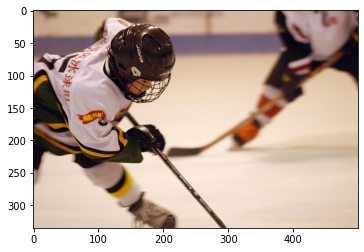

hockey player in red and white collides down the ice


In [36]:
image='/content/drive/MyDrive/Flickr8k_Dataset/494921598_af73bda568.jpg'
photo_feature=extract_photo_features(image)
caption=generate_captions(max_length, tokenizer, caption_model, photo_feature)
img=plt.imread(image)
plt.imshow(img)
plt.show()
print(' '.join(caption))

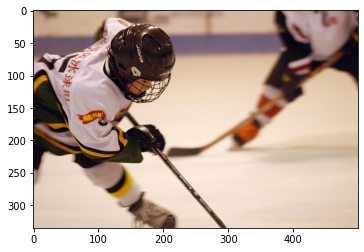

In [37]:
image='/content/drive/MyDrive/Flickr8k_Dataset/494921598_af73bda568.jpg'
photo_feature=extract_photo_features(image)
img=plt.imread(image)
plt.imshow(img)
plt.show()
caption_b,scores=Beam_search(10, tokenizer, max_length, caption_model, photo_feature)

In [38]:
pd.options.display.max_colwidth = 200
table=pd.DataFrame(caption_b, columns=['captions'])
table['scores']=np.round(scores,decimals=4)
table

,captions,scores
0,player in red and black bumps the ball,-0.0314
1,player in red and black bumps the ball,-0.0243
2,player in red and black bumps the ball,-0.0217
3,player in red and black bumps the ice,-0.0208
4,player in red and black bumps the ice hockey puck,-0.0180
5,player in red and black bumps the ice hockey puck,-0.0180
6,player in red and black bumps the ice hockey puck,-0.0178
7,player in red and black bumps the ice,-0.0168
8,player in red and black bumps the ice hockey puck,-0.0156
9,player in red and black bumps the ice hockey puck,-0.0152


# Insights:
1. Model can be trained on much larger datasets to achieve more accurate caption generation on the test image, reason being if only the model has been trained on an image similar to the test image then it has the chance to be provide good predictions. For that to happen the model needs to be trained on huge datasets.
2. Bleu score for beam width=5 was used as metric due to computation time & resource constraint. Try for beam width>5 which would give better Bleu score.
3. The model was trained for 30 epochs. Try training for more epochs for better results but also avoiding overfitting.
4. Implementing caption generation with attention architecture will also improve the model.